In this notebook we will refine and scale the best approach we've found for modeling my job preferences, which is a linear regression model applied to the data after it goes through FE approach 3.

I will be working with an entirely new and larger dataset and additionally I will be refining the data scraping process/code to make sure it is in good shape.

In the end, I ended up scraping info from 244 more job postings and appending that to the original 107 job postings. What's shown in this notebook is the results of executing the pipeline we have established so far on this larger dataset. The key takeaways are that accuracy go down and data processing time prior to model training increase and that these should be properly managed in order for the final tool to work well.   

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import time

def scrape_job_postings(csv_file):
    # Open the CSV file
    with open(csv_file, 'r', newline='') as file:
        reader = csv.reader(file)
        #csv_writer = csv.writer(file)
        row_num = 1

        for row in reader:
          text_file_path = f"drive/MyDrive/scraped_text/posting{row_num}.txt"
          with open(text_file_path, 'w') as file:
            job_link = row[0] # Assuming the job links are in the first column
            # Send a GET request to the job link
            # request web page
            resp = requests.get(fr"{job_link}")

            if resp.status_code == 200:
              # get the response text. in this case it is HTML
              html = resp.text
              # Parse the HTML content
              soup = BeautifulSoup(html, 'html.parser')

            else:
              time.sleep(1)
              # request again
              resp = requests.get(job_link)
              if resp.status_code == 200:
                # get the response text. in this case it is HTML
                html = resp.text
                # Parse the HTML content
                soup = BeautifulSoup(html, 'html.parser')

              else:
                print("Failed to retrieve job posting from", job_link)
                row_num += 1
                continue

            # get position, company, location, pay
            x = soup.get_text().split('\n')
            # Remove elements with only whitespace
            filtered_list = [string for string in x if string.strip()]

            for i in filtered_list:
              if i.find('Join now') != -1 and filtered_list[filtered_list.index(i) + 1].find('Sign in') != -1:
                position = filtered_list[filtered_list.index(i) + 2]
                company = filtered_list[filtered_list.index(i) + 3]
                location = filtered_list[filtered_list.index(i) + 4]
                break

            for i in filtered_list:
              if i.find('Base pay range') != -1:
                salary_index = filtered_list.index(i) + 1
                salary = filtered_list[salary_index]
                salary = salary.lstrip()
                salary = "N/A" if (salary.find("$") == salary.find("€") == salary.find("£") == -1) else salary
                break
              else:
                salary = "N/A"

            file.write(f"position is {position}\n")
            file.write(f"company is {company}\n")
            file.write(f"location is {location}\n")
            file.write(f"salary is {salary}\n\n")

            #get seniority level, employment type, job function, and industries
            spans = soup.find_all('span', {'class': "description__job-criteria-text description__job-criteria-text--criteria"})
            for span in spans:
              parent_tags = span.parent.find_all("h3", {'class': "description__job-criteria-subheader"})
              for tag in parent_tags:
                field = tag.contents[0].strip()
                #print(span.parent.find_all("h3", {'class': "description__job-criteria-subheader"}))
              value = span.contents[0].strip()
              file.write(f"{field} is {value}\n")
            file.write("\n")

            # get main body text
            characters_per_line = []

            # Extract text content from the HTML
            text_content = soup.get_text()

            # Split the text into lines
            lines = text_content.splitlines()

            # Calculate the number of characters in each line
            for line in lines:
              characters_per_line.append(len(line))

            body_len = max(characters_per_line)
            body_idx = characters_per_line.index(body_len)
            body_text = lines[body_idx]
            file.write(body_text)
          row_num += 1



# Example usage
#csv_file_path = "job_links.csv"
#scrape_job_postings(csv_file_path)

In [2]:
csv_file_path = "postings.csv"
scrape_job_postings(csv_file_path)

After curating a new dataset of 244 posting links with ratings contained in 'postings.csv', I ran 'scrape_job_postings' on postings.csv. I ended up with 244 text files saved in "drive/MyDrive/scraped_text/". Now I run the next three code blocks to generate a salary JSON file for each of the 244 job postings.

In [3]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00


In [4]:
import os
from openai import OpenAI
import json

def generate_salary_json_file(ind, salary_val):

  prompt = "Take the following python data and infer the minimum and maximum of the salary range, and fill out their values as floating point numbers with three decimal places in units of thousands in a JSON dictionary, with 'salary_min' and 'salary_max' being the keys. If the data given is ['$150,000.00/yr - $220,000.00/yr'] then you should return {'salary_min': 150, 'salary_max': 220}, but make sure to use double quotes to enclose the key names. If you infer that info is in dollars per hour, convert the numbers to annual salary in thousands so output is same regardless of given units. Note that $48/hr is equal to $100,000/yr. Put 'N/A' under the fields if the required information is not given. If only one number is given put it under 'salary_max'. Return only the JSON dictionary. I want you to do it, not to tell me how to code it. I want you to do it for: "

  prompt = prompt + "/n" + str(salary_val)

  client = OpenAI(
    # This is the default and can be omitted
    api_key="sk-proj-2Iut0hiaVnKHtMPvhKcqT3BlbkFJ4bGC2VbEkNT1SN2eYghm",
  )

  chat_completion = client.chat.completions.create(
      messages=[
          {
              "role": "user",
              "content": prompt,
          }
      ],
      model="gpt-3.5-turbo",
  )
  json_files_dir = "drive/MyDrive/salariesJSON/"
  json_data = json.loads(chat_completion.choices[0].message.content.strip("`").strip('json').strip())
  json_file_path = json_files_dir + f'posting{ind}.json'
  # Write JSON data to the file
  with open(json_file_path, "w") as json_file:
    json.dump(json_data, json_file)

  return json_file_path


In [6]:
ind = 1
for file in os.listdir("drive/MyDrive/scraped_text/"):
  assert int(file.strip(".txt").strip("posting")) == ind
  with open(os.path.join("drive/MyDrive/scraped_text/", file), "r") as f:
    lines = f.readlines()
  salary_line = lines[3]
  salary_string = salary_line.strip("\n").strip("salary is ")
  generate_salary_json_file(ind, salary_string)
  ind += 1

Now I need to run the below code in order to combine the scraped text data and ratings for the new dataset with those from the old dataset (original 107 job postings).

In [14]:
links_csv_path = "postings.csv"
old_links_updated_ratings_path = "ReproduceRatings.csv"

import pandas as pd
links_dataframe = pd.read_csv(links_csv_path, header=None, names=['url', 'rating'])
old_links_updated_ratings_df = pd.read_csv(old_links_updated_ratings_path, header=None, names=['rating'])
#links_dataframe.head()
#print(links_dataframe.loc[0, 'rating'])

# let's snakecase our column names to avoid having spaces in them
# also we add a rating column at the end of the list to store the target variable
salary_columns = ["min_salary", "max_salary"]
# Initialize DataFrame with column names
salary_df = pd.DataFrame(columns=salary_columns)

import os
import json
salary_json_files_path = "drive/MyDrive/salariesJSON/"

for i in range(1, links_dataframe.shape[0] + 1):
  row_num = salary_df.last_valid_index()
  if row_num == None:
    row_num = 0
  else:
    row_num = row_num + 1
  assert i == row_num + 1

  salary_json_file_path = os.path.join(salary_json_files_path, f'posting{i}.json')
  # Read salary JSON file
  with open(salary_json_file_path, 'r') as json_file:
    json_data = json.load(json_file)
  min_salary = json_data["salary_min"]
  max_salary = json_data["salary_max"]
  salary_df.at[row_num, 'min_salary'] = min_salary
  salary_df.at[row_num, 'max_salary'] = max_salary


old_salary_json_files_path = "drive/MyDrive/jobSalaries/"
for i in range(1, old_links_updated_ratings_df.shape[0] + 1):
  row_num = salary_df.last_valid_index()
  row_num = row_num + 1
  salary_json_file_path = os.path.join(old_salary_json_files_path, f'row{i}.json')
  with open(salary_json_file_path, 'r') as json_file:
    json_data = json.load(json_file)
  min_salary = json_data["salary_min"]
  max_salary = json_data["salary_max"]
  salary_df.at[row_num, 'min_salary'] = min_salary
  salary_df.at[row_num, 'max_salary'] = max_salary

import numpy as np
# Replace 'N/A' with NaN in the whole DataFrame
salary_df.replace('N/A', np.nan, inplace=True)

# let's snakecase our column names to avoid having spaces in them
# also we add a rating column at the end of the list to store the target variable
df_columns = ["posting_text", "rating"]
# Initialize DataFrame with column names
df = pd.DataFrame(columns=df_columns)

for i in range(1, links_dataframe.shape[0] + 1):
  row_num = df.last_valid_index()
  if row_num == None:
    row_num = 0
  else:
    row_num = row_num + 1
  assert i == row_num + 1
  text_file_path = f'drive/MyDrive/scraped_text/posting{i}.txt'
  with open(text_file_path, 'r') as file:
    # Read the entire content of the file into a string
    file_contents = file.read()
  df.at[row_num, 'posting_text'] = file_contents
  rating = links_dataframe.loc[row_num, 'rating']
  df.at[row_num, 'rating'] = rating

for i in range(1, old_links_updated_ratings_df.shape[0] + 1):
  row_num = df.last_valid_index()
  row_num = row_num + 1
  text_file_path = f'drive/MyDrive/text_files2/row{i}.txt'
  with open(text_file_path, 'r') as file:
    # Read the entire content of the file into a string
    file_contents = file.read()
  df.at[row_num, 'posting_text'] = file_contents
  rating = old_links_updated_ratings_df.loc[i - 1, 'rating']
  df.at[row_num, 'rating'] = rating


# Iterate over columns and fill NaN values with the mode of each column
for col in salary_df.columns:
  mode_val = salary_df[col].mode()[0]
  salary_df[col].fillna(mode_val, inplace=True)  # Fill NaN values with the mode

# Concatenate the DataFrames
concatenated_df = pd.concat([df, salary_df], axis=1)

print(concatenated_df.isnull().sum())

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(concatenated_df[['posting_text', 'min_salary', 'max_salary']], concatenated_df['rating'], test_size=0.2, random_state=21)

# Step 2: Initialize and fit TF-IDF vectorizer on the training data only
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['posting_text'])
# Convert TF-IDF matrix to DataFrame
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_train.index)

# Step 3: Transform the test data using the fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test['posting_text'])
# Convert TF-IDF matrix to DataFrame
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_test.index)

new_df = X_train.drop(columns='posting_text')
new_test_df = X_test.drop(columns='posting_text')
X_train = pd.concat([new_df, X_train_tfidf_df], axis=1)
X_test = pd.concat([new_test_df, X_test_tfidf_df], axis=1)


# Now X_train and X_test are ready to be passed to a model

posting_text    0
rating          0
min_salary      0
max_salary      0
dtype: int64


Excellent, so this step took 30 seconds when the TfidfVectorizer had a maximum of 5000 features.

In [10]:
X_train

,min_salary,max_salary,00,000,00applications,00salary,00the,030,040,069,...,youtube,yr,zarr,zeal,zero,zimmer,zipbio,zone,zones,zoom
91,115.0,224.000,0.039410,0.044959,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.042843,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
68,105.7,205.600,0.037373,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.040629,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
200,129.0,228.000,0.025886,0.118126,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.028142,0.0,0.0,0.0,0.0,0.0,0.15109,0.040481,0.0
142,115.0,200.000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
165,59.0,69.000,0.047667,0.054380,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.051820,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,115.0,200.000,0.027122,0.030941,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.029485,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
207,10.0,98.354,0.027097,0.046370,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.029458,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
136,55.0,65.000,0.061615,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.066983,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
295,115.0,200.000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0


In [11]:
X_test

,min_salary,max_salary,00,000,00applications,00salary,00the,030,040,069,...,youtube,yr,zarr,zeal,zero,zimmer,zipbio,zone,zones,zoom
212,88.0,110.0,0.029041,0.066261,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.031571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,117.0,137.0,0.027549,0.031428,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.029949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,204.0,259.0,0.024320,0.055489,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.026439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,115.0,200.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220,115.0,200.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,100.0,140.0,0.046280,0.105593,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.050312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,115.0,200.0,0.037240,0.042484,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.040485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,115.0,200.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,175.0,250.0,0.022790,0.051999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.024776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now let's try to train a linear regression model and evaluate accuracy of its predictions.

In [17]:
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Train a regression model instead of SVM classifier
regression_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = regression_model.predict(X_test)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Round the predictions
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate accuracy using the rounded predictions and actual target values
accuracy = accuracy_score(y_test.tolist(), y_pred_rounded)

print("accuracy is", accuracy)

Mean Absolute Error: 2757.600202560053
Mean Squared Error: 13657587.459157357
accuracy is 0.028169014084507043


We see that our model does not have average accuracy or error we would have liked, which are around 65% and .45 respectively. What about for other train-test splits? The above were for train-test split with random_state = 507.

In [15]:
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Train a regression model instead of SVM classifier
regression_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = regression_model.predict(X_test)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Round the predictions
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate accuracy using the rounded predictions and actual target values
accuracy = accuracy_score(y_test.tolist(), y_pred_rounded)

print("accuracy is", accuracy)

Mean Absolute Error: 2022.834416397427
Mean Squared Error: 7408898.342936062
accuracy is 0.04225352112676056


For random_state=42, we get better accuracy but higher values for mean absolute and squared error.

In [7]:
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Train a regression model instead of SVM classifier
regression_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = regression_model.predict(X_test)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Round the predictions
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate accuracy using the rounded predictions and actual target values
accuracy = accuracy_score(y_test.tolist(), y_pred_rounded)

print("accuracy is", accuracy)

Mean Absolute Error: 0.4979686437495676
Mean Squared Error: 0.3747900415332308
accuracy is 0.5492957746478874


For random_state=95, the accuracy and error are both better.

In [5]:
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Train a regression model instead of SVM classifier
regression_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = regression_model.predict(X_test)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Round the predictions
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate accuracy using the rounded predictions and actual target values
accuracy = accuracy_score(y_test.tolist(), y_pred_rounded)

print("accuracy is", accuracy)

Mean Absolute Error: 0.5312161805463228
Mean Squared Error: 0.44099966905080923
accuracy is 0.4788732394366197


This is for random_state=13.

In [3]:
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Train a regression model instead of SVM classifier
regression_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = regression_model.predict(X_test)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Round the predictions
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate accuracy using the rounded predictions and actual target values
accuracy = accuracy_score(y_test.tolist(), y_pred_rounded)

print("accuracy is", accuracy)

Mean Absolute Error: 0.5310850698823856
Mean Squared Error: 0.5534818207043886
accuracy is 0.5915492957746479


This is for random_state=21.

Result averages for this 5-fold cross validation of the linear regression model with this dataset, where the TfidfVectorizer has a *maximum of 5000 features*.

| accuracy | MAE | MSE |
|-------|------------|---------------------|
| 54.9% | .559 | .541 |

Perhaps since we scaled up the dataset we should tweak our TfidfVectorizer to include more features, and that will help our performance. We'll increase max_features from 5000 to 10000 in the appropriate code block and then rerun these trials with linear regression for the 5 selected train-test splits. We will report the result averages below.   


| accuracy | MAE | MSE |
|-------|------------|---------------------|
| 53.8% | .543 | .514 |

Evidently, there is not much of a change in performance from allowing 10000 instead of 5000 features for our TfidfVectorizer. As a final thing to try I will see how these results compare to those from allowing only 500 features for our TfidfVectorizer. I will report averages below for accuracy, MAE, and MSE, just as I did when trying max_features=5000 and 10000 respectively.

We see with the first train-test split when we do max_features=500 that the model completely falls apart and average error is in the thousands. We need not report results for max_features=500 since they are so obviously bad.

Clearly we are not prediciting as accurately as we were before with the original dataset of 107 postings. I will quickly evaluate some of other models with this scaled dataset to see if any of them outperform linear regression.

In [3]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Initialize the HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Test the classifier on the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Accuracy: 0.5211267605633803
Mean Absolute Error: 0.6056338028169014
Mean Squared Error: 0.9154929577464789


This was for random_state=95 in the train-test split. Linear regression's predictions had much less error.

In [5]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Initialize the HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Test the classifier on the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Accuracy: 0.49295774647887325
Mean Absolute Error: 0.6197183098591549
Mean Squared Error: 0.8732394366197183


Again we see inferior results with HistGradientBoostingClassifier. We should try a RandomForestClassifier next.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=300)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Test the classifier on the testing data
y_pred = rf_classifier.predict(X_test)


# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

mae = mean_absolute_error(y_test, y_pred)
print("mae:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 0.49295774647887325
mae: 0.6619718309859155
Mean Squared Error: 1.028169014084507


And the Random Forest did worse than HGBC. Lastly, we will evaluate XGBoost and Logistic Regression.

In [9]:
!pip install xgboost

In [10]:
import xgboost as xgb

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the classifier on the training data
xgb_classifier.fit(X_train, y_train)

# Test the classifier on the testing data
y_pred = xgb_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Accuracy: 0.5352112676056338
Mean Absolute Error: 0.5774647887323944
Mean Squared Error: 0.8309859154929577


XGBoost faired a little better than RandomForest and HistGradientBoostingClassifier but not as well as Linear Regression.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a Logistic Regression model
# By default, LogisticRegression uses OvR for multi-class classification
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence if needed

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Accuracy: 0.5915492957746479
Mean Absolute Error: 0.5774647887323944
Mean Squared Error: 0.971830985915493


Interestingly, logistic regression had better accuracy but substantial error, particularly squared error. This is for random_state=507.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a Logistic Regression model
# By default, LogisticRegression uses OvR for multi-class classification
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence if needed

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Accuracy: 0.5492957746478874
Mean Absolute Error: 0.6901408450704225
Mean Squared Error: 1.2816901408450705


Again accuracy of logistic regression was not bad but the error is quite large for random_state=42. I think it's safe to assume linear regression is still the best model and we should move forward with deploying the AI tool, using linear regression as our model.

Let's quickly take a look at the distribution of data in the salary columns to see if anything is unusual and could be detrimenting our model.

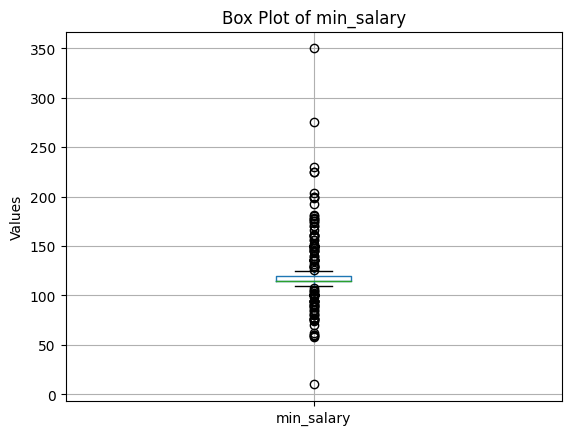

In [15]:
import matplotlib.pyplot as plt

# Create a box plot of a specific column (replace 'column_name' with the name of your column)
X_train.boxplot(column='min_salary')

# Add title and labels
plt.title('Box Plot of min_salary')
plt.ylabel('Values')

# Show the plot
plt.show()

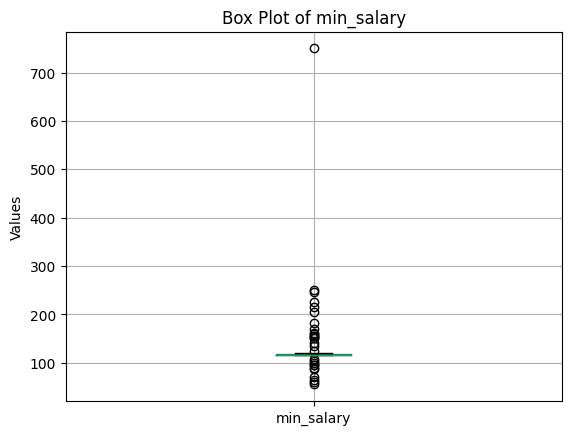

In [16]:
# Create a box plot of a specific column (replace 'column_name' with the name of your column)
X_test.boxplot(column='min_salary')

# Add title and labels
plt.title('Box Plot of min_salary')
plt.ylabel('Values')

# Show the plot
plt.show()

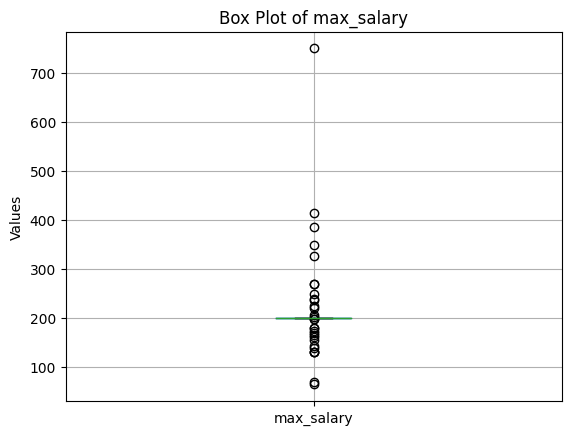

In [18]:
# Create a box plot of a specific column (replace 'column_name' with the name of your column)
X_test.boxplot(column='max_salary')

# Add title and labels
plt.title('Box Plot of max_salary')
plt.ylabel('Values')

# Show the plot
plt.show()

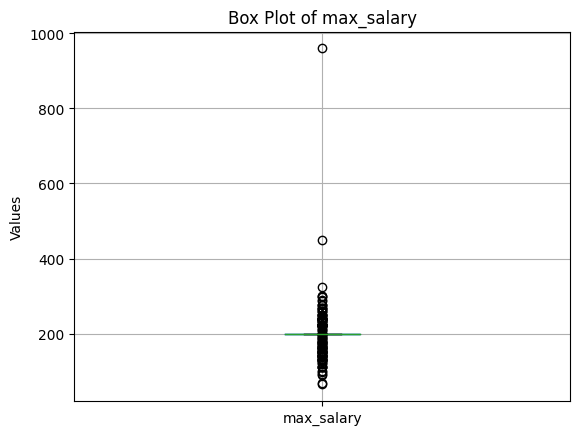

In [19]:
# Create a box plot of a specific column (replace 'column_name' with the name of your column)
X_train.boxplot(column='max_salary')

# Add title and labels
plt.title('Box Plot of max_salary')
plt.ylabel('Values')

# Show the plot
plt.show()

Although we see some outliers, they are not orders of magnitude different from the modes of their respective datasets. I don't believe these are detrimenting performance but we can perhaps define rules for when to remove outliers later on.

The two main hurdles we have found for scaling this prototype to larger datasets are the following:
1. ensuring that accuracy doesn't decrease and error doesn't increase as the dataset gets larger
2. ensuring that the feature engineering step can be executed reliably and as quickly as possible, since with one CPU the feature engineering step can take on the order of minutes if the dataset is large enough.

These are two of the biggest challenges that will need to be addressed when scaling the model. In addition, the ChatGPT OpenAI API calls can rack up large costs if applied to large amounts of datapoints which is why I only think it should be used for my prototyping.

It may or not be feasible to incorporate in the next month, but using a free open source LLM implementation to generate the salary descriptions in JSON format is the way that I would need to go in order for the final product to be cost-efficient enough to run as a free service.  

Nevertheless we need to embark on the next step, building the damn thing!